In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

summ = pd.read_csv('summtab.csv')

cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
cross2['Part'] = 2

In [2]:
mlist1 = ['OII I','OIII I']
mlist2 = ['OII I','OIII I','OIV I']

In [24]:
def cut(srcn,cut=10,npoints=False,time=False,retstd=True,retrange=False,calib=False,plot=True,text=False,statistic='median',glob=False,retsplit=False,window=200): #decide whether to do fixed chunks or fixed factor chunks or fixed number of points
    '''Divide LC into chunks and find median in each
    Division can be by number of points per piece or by total number of pieces.
    cut: number of pieces or number of points per piece or number of days per piece, depending on bool npoints and bool time
    npoints: if True, cut determines (approx) number of points per chunk; if False, cut determines total number of pieces
    time: if True, cut gives number of days included in each chunk
    retstd: return standard deviation of median values
    retrange: return range of median values
    calib: calibrate data by setting the medians of OII,OIII, and OIV to the same
    plot: plot LC
    retsplit: if True, return right after splitting; returns the split days,I mags, and det I lists
    '''
    #make sure plt.text not used if not plotting
    if not plot: text = False
    if srcn in cross['src_n']:
        c = cross
        mlist = mlist1
    else:
        c = cross2
        mlist = mlist2
    if glob: 
        global iband
        iband = o.getIV(srcn,c,calib=calib,both=False,stack=True,plot=plot,mlist=mlist,printall=False)
    else: iband = o.getIV(srcn,c,calib=calib,both=False,stack=True,plot=plot,mlist=mlist,printall=False)
    #detrend with spline
    flatten,trend = o.splinedetrend(iband,retspline=True,window=window)
    if npoints: cut = int(len(iband)/cut)+1
    #time cut means #days per piece, so divide total time by that to get number of pieces
    if time: cut = int((iband['MJD-50000'][-1:]-iband['MJD-50000'][:1])/cut)
    imagsplit = np.array_split(iband['I mag'],cut)
    splinesplit = np.array_split(iband['I detrend'],cut)
    #retsplit means just split up the values and return rather than calculating stat
    if retsplit:
        timesplit = np.array_split(iband['MJD-50000'],cut)
        return timesplit,imagsplit,splinesplit
    stats = []
    #TO DO: option to calculate statistic on detrended instead
    for i in range(cut):
        if statistic=='median': stat = np.median(imagsplit[i])
        elif statistic=='mean': stat = np.mean(imagsplit[i])
        elif statistic=='max': stat = np.max(imagsplit[i])
        elif statistic=='min': stat = np.min(imagsplit[i])
        elif statistic=='IQR': stat = scipy.stats.iqr(imagsplit[i])
        elif statistic=='skew': stat = scipy.stats.skew(imagsplit[i])
        elif statistic=='kurtosis':stat = scipy.stats.kurtosis(imagsplit[i])
        else: print('please enter valid statistic');return
        stats.append(stat)
    #add standard deviation of medians to plot
    if text:
        plt.text(np.median(iband['MJD-50000'])-1000,np.min(iband['I mag'])+.04,f'stdev of {statistic}s of {cut} chunks: {np.std(stats):.2f}')
    if retstd and retrange: return np.std(meds), np.max(meds)-np.min(stats)
    elif retstd: return np.std(stats)
    elif retrange: return p.max(stats)-np.min(stats)
    else: return stats

[14.759, 14.828, 14.764, 14.7895, 14.772, 14.721]

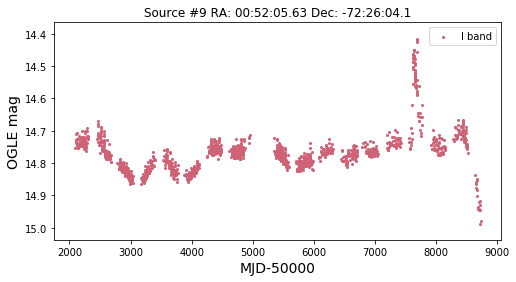

In [4]:
cut(9,cut=1000,retstd=False,glob=True,time=True)

# test cut() as indicator of long-term variability
- do I agree by-eye?
- particularly should identify very long-term trends/big dips rather than periodic high variability

- change in min (peak) is pretty good, and could be divided by overall standard deviation to be independent of range

0.14571533893176827
divided by stdev:  0.483418684029013
0.09986270575144601
divided by stdev:  0.8054970260901241
0.26194732294871803
divided by stdev:  1.5534154138910412
0.053471487729443365
divided by stdev:  0.14371209551337336
0.29771019465245113
divided by stdev:  1.1215807703653655
0.23156942803401323
divided by stdev:  0.9473163948010519
0.04568851059073803
divided by stdev:  0.6946674330658333
0.05315787806148797
divided by stdev:  0.8995179144911379
0.12769588873569887
divided by stdev:  0.9104752485519576


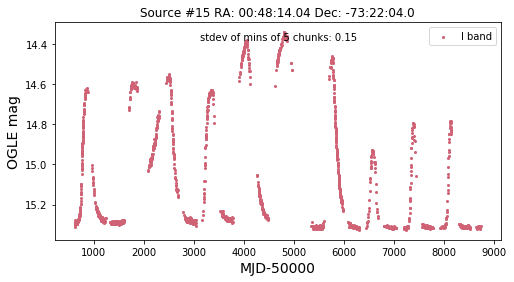

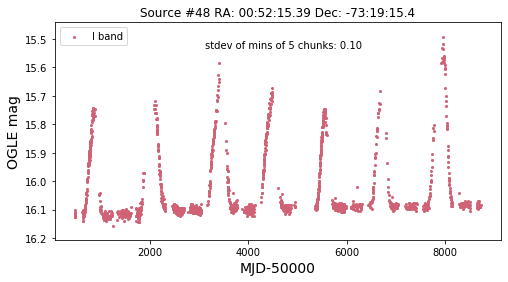

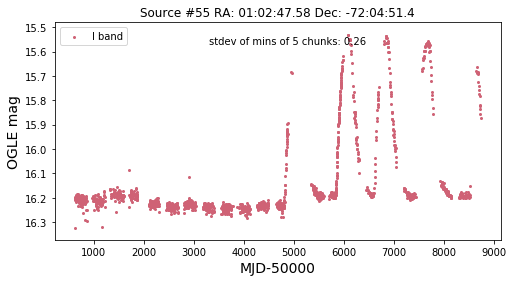

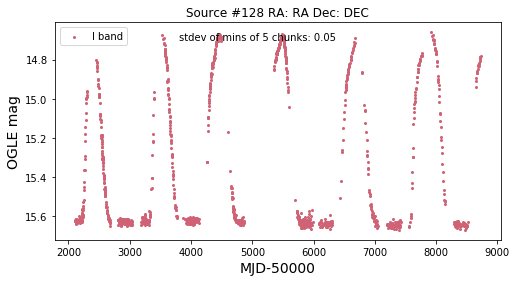

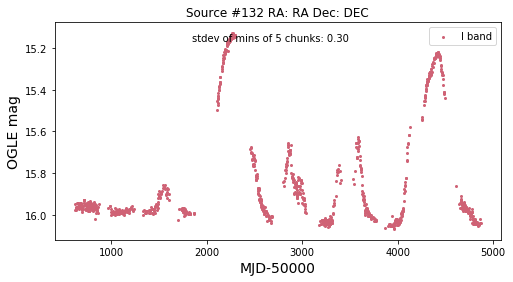

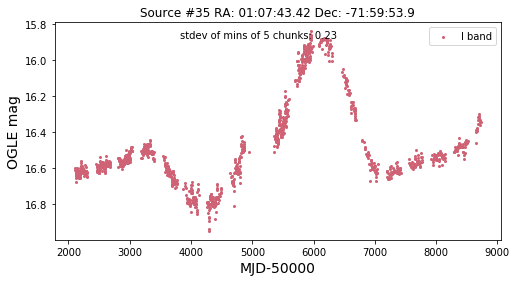

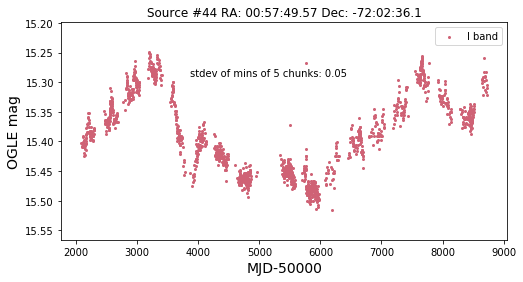

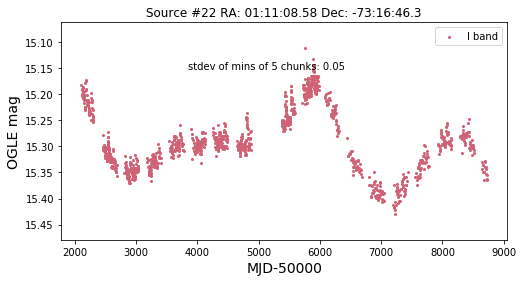

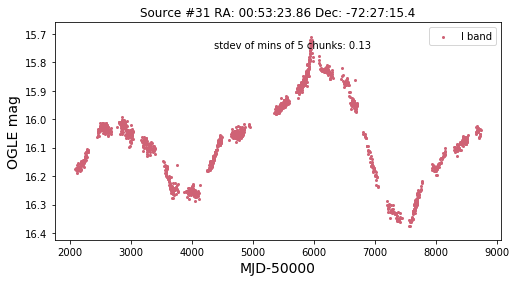

In [5]:
for s in [15,48,55,128,132,35,44,22,31]:
    stat = cut(s,cut=5,retstd=True,text=True,glob=True,statistic='min')
    print(stat)
    print('divided by stdev: ',stat/np.std(iband['I mag']))

In [6]:
#same sources but max (faintest point) -- these combined could be good way to confirm base
#faint base sources have lower change in max than the last four, which don't have a base
for s in [15,48,55,128,132,35,44,22,31]:
    stat = cut(s,cut=5,retstd=True,text=True,glob=True,plot=False,statistic='max')
    print(stat)


0.006675327707311864
0.016906803364325776
0.043471369888698576
0.010707007051458833
0.01899894733926138
0.1910430318017384
0.044048155466488936
0.03548520818594682
0.09917782010106878


# Look for Changes in Phase-Folded Data in Chunks of LC
- use periods that are established from X-ray or otherwise confident for now
    - future: good way of disproving period
- use properties dictionaries and see how they change
    - correlations with magnitude or nearby color properties?
- have option to plot on one plot or double check by separate plots
    - need to update phase step to help with a global ylim (or can normalize?)
- **first have cut function return detrended I mag as well**

In [142]:
def detvar(src,num=10,plot=True):
    '''Use chunks to find changes in detrended variability
    Give mean I mag, stdev of detrended data, and mean time for each chunk
    Two plots: stdev vs. mean and stdev overlain on I band LC'''
    times,mags,det = cut(src,cut=num,glob=True,plot=False,retsplit=True)
    means = [] #mean I mag in segment
    stds = [] #stdev I mag in detrended segment
    mtimes = []
    for i in range(len(times)):
        means.append(np.mean(mags[i]))
        stds.append(np.std(det[i]))
        mtimes.append(np.mean(times[i]))
    fig,ax = plt.subplots(1,2,figsize=(12,4))
    im = ax[1].scatter(means,stds,c=mtimes)
    fig.colorbar(im,label='MJD-50000')
    ax[1].set_xlabel('Mean I band')
    ax[1].set_ylabel('Stdev Detrended I')
    ax[0].scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=4)
    #flip y axis
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    ax[0].set_ylim(maxi+.05,mini-.05)
    ax1 = ax[0].twinx()
    ax1.scatter(mtimes,stds,color='black')
    ax[0].tick_params(axis='y', labelcolor=pink)
    plt.subplots_adjust(wspace=.3)
    return mtimes,means,stds

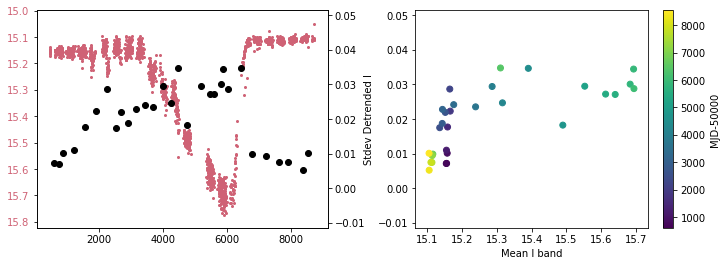

In [220]:
test = detvar(41,num=30)

In [173]:
def orbchunks(src,bp,num=5,pbins=16,det=True,findpd=False,plotlc=False):
    '''Make table of phase-folded properties after dividing LC into chunks'''
    times,mags,det = cut(src,cut=num,glob=True,plot=False,retsplit=True)
    fig = plt.figure(figsize=(22,4*int(num/5)))
    c = 1
    if findpd:
        #get period from summ table
        row = summ[summ['src_n']==src]
        #if there's a manually-filled best period, use that
        if float(row['best period'])>0: bp = float(row['best period'])
        #otherwise use best period from auto analysis
        else:bp = float(row['best auto det pd'])
    means = [] #calculate means of segments without detrending to get brightness
    for i in range(len(times)):
        ax = fig.add_subplot(1*int(num/5),5,c)
        #make segment into astropy table
        ib = Table({'MJD-50000':times[i],'I mag':mags[i],'I detrend':det[i]})
        #construct dictionary (could be made more efficient since step calculated twice)
        pdict = o.combine(src,cross,full,iband=ib,det=det,pd=bp,pbins=pbins,close=True,testbins=False)
        #get values for step function
        mid,avg,err = o.meanphase(ib,bp,pbins=pbins,det=det,double=True,sterr=True,stdev=True,divide=True)
        ax.step(mid,avg,where='mid',color='black',label=f'{bp:.2f}d')
        if c==1: ax.legend()
        plt.errorbar(mid,avg,yerr=err,color='grey',alpha=0.5)
        maxi,mini = np.nanmax(avg)+np.nanmax(err),np.nanmin(avg)-np.nanmax(err)
        ax.set_ylim(maxi,mini)
        #calculate mean I mag and add to list
        meanmag = np.mean(mags[i])
        means.append(meanmag)
        #turn first dictionary into main table
        if c==1:
            main = pd.DataFrame(pdict,index=[0])
            if det: ax.set_ylabel('Detrended I mag')
            else: ax.set_ylabel('I mag')
            ax.set_xlabel('Phase')
        #otherwise make table and stack it with main
        else: 
            temp = pd.DataFrame(pdict,index=[c-1])
            #add new row to table by concatenation
            main = pd.concat([main,temp])
        c+=1
    #add I mag means to table
    main['mean I'] = means
    #plot LC with different colors for different segments
    if plotlc:
        plt.figure(figsize=(8,4))
        maxi,mini = 0,np.inf
        for i in range(len(times)):
            plt.scatter(times[i],mags[i],s=4)
            if np.max(mags[i])>maxi:maxi = np.max(mags[i])
            if np.min(mags[i])<mini:mini = np.min(mags[i])
        plt.ylim(maxi+.04,mini-.04)
        plt.ylabel('I mag',fontsize=13)
        plt.xlabel('MJD-50000',fontsize=13)
    return main

,period,amp,phase diff,phase max,phase min,shape,diff mean,mean,skew,kurtosis,symm sum,mean err,mean I
0,102.97,0.023610,0.4375,0.40625,0.96875,FRED,0.010997,16.950299,-0.340286,-1.197274,0.002271,0.003310,16.809130
1,102.97,0.027078,0.6250,0.65625,0.03125,FRED,0.015135,16.952393,0.052830,-0.559076,0.003360,0.003597,16.927344
2,102.97,0.031173,0.6250,0.53125,0.90625,not FRED,0.016797,16.951524,-0.020387,-1.393267,0.009080,0.004100,17.050838
3,102.97,0.030611,0.2500,0.53125,0.28125,not FRED,0.015982,16.951770,-0.045047,-0.941824,0.008393,0.003786,17.061179
4,102.97,0.038868,0.5625,0.46875,0.90625,not FRED,0.015505,16.949853,-0.631274,-0.770604,0.009266,0.004297,16.919721


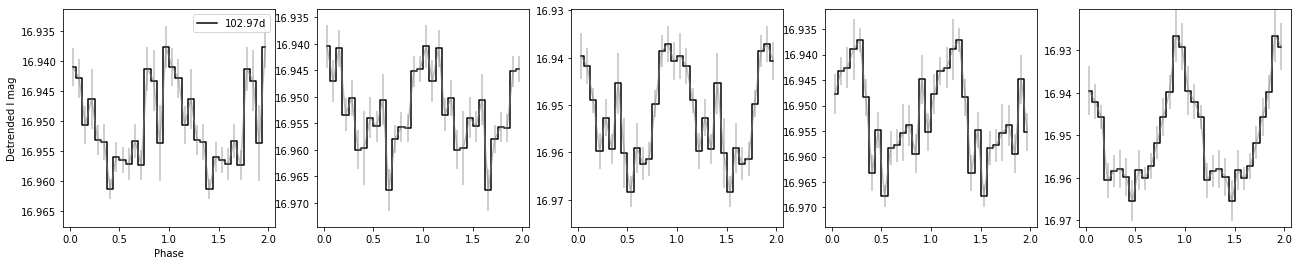

In [174]:
main = orbchunks(67,102.97)
main

## Sources to Analyze for Now: Strong Period Signals 
- do big dip sources often have strong period signals?
- 96,115,141,19,2,22,64,4,9,10,16,17,23,25,26,28,30,34,36,40,45,48,50,62,63
- first check for best period; otherwise use best det
- 34 may not be good but curious to see
- later: good way to monitor changing phase of optical max


,period,amp,phase diff,phase max,phase min,shape,diff mean,mean,skew,kurtosis,symm sum,mean err,mean I
0,17.5496,0.062306,0.5625,0.78125,0.21875,FRED,0.023514,14.853532,-0.709424,-0.777160,0.013350,0.003062,14.842420
1,17.5496,0.069346,0.6250,0.90625,0.28125,FRED,0.021109,14.847758,-1.031897,-0.451186,0.010674,0.002171,14.842771
2,17.5496,0.056182,0.6875,0.90625,0.21875,FRED,0.017275,14.849937,-0.951885,-0.485140,0.011436,0.002245,14.858039
3,17.5496,0.060772,0.7500,0.90625,0.15625,FRED,0.020611,14.849642,-1.009689,-0.477801,0.012650,0.002558,14.857984
4,17.5496,0.016865,0.4375,0.84375,0.40625,not FRED,0.009092,14.857468,0.442299,-0.037907,0.001672,0.003616,14.905631


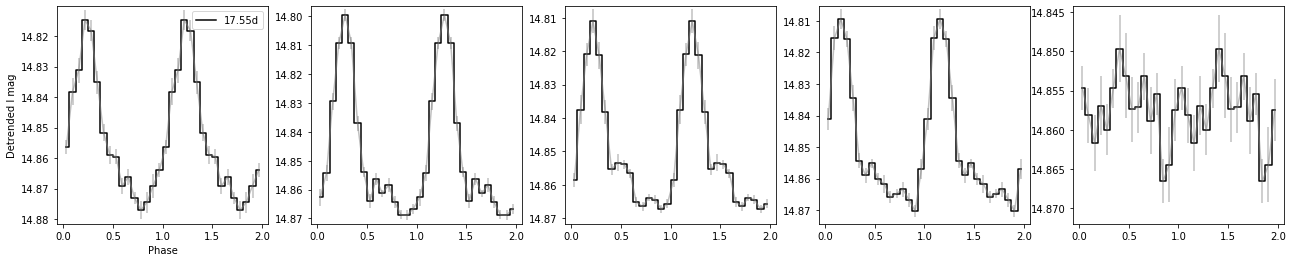

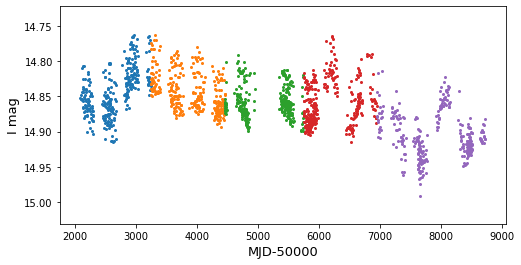

In [176]:
orbchunks(96,0,findpd=True,plotlc=True) #plotted LC b/c curious about what was happening at the end

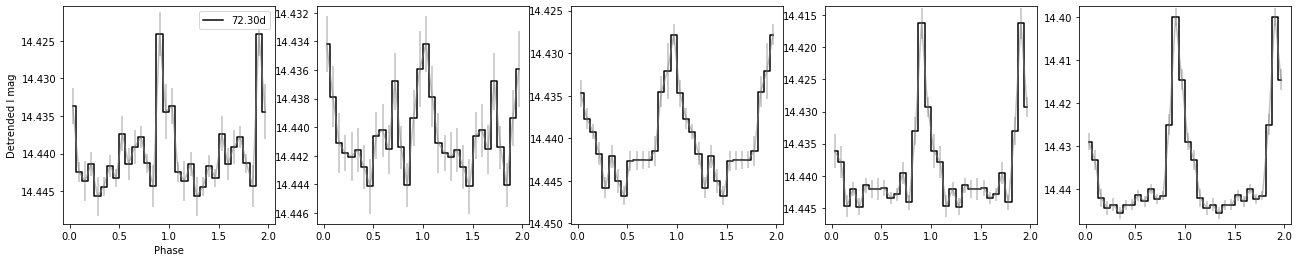

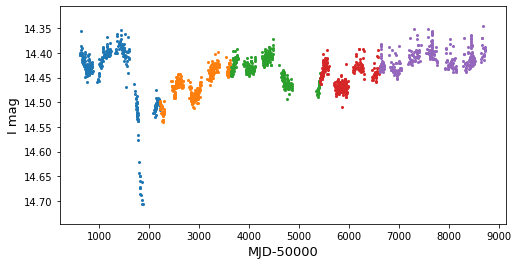

In [178]:
orb = orbchunks(115,0,findpd=True,plotlc=True)

In [203]:
summ[summ['src_n']==141]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part,I IQR,aperiodic quiescence
107,141,19.91226,-73.50316,0.0,0.72,0.0,0.175075,NaN,15.619686,0.016848,...,NaN,NaN,0.271742,-0.128521,0.279669,-0.494353,5.183714,2.0,0.024,NO


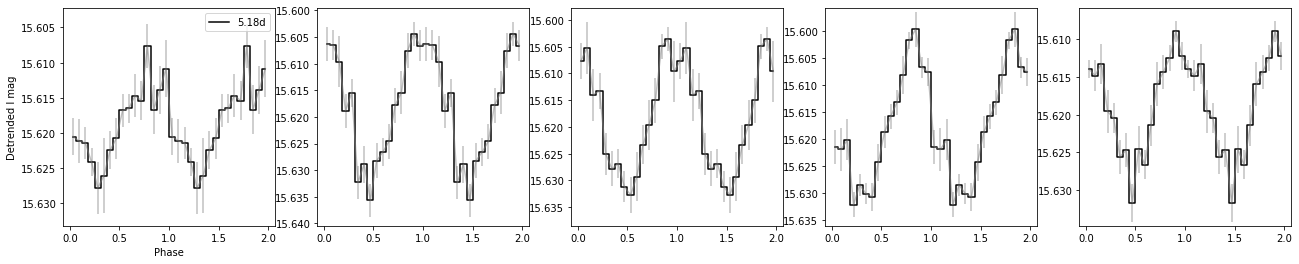

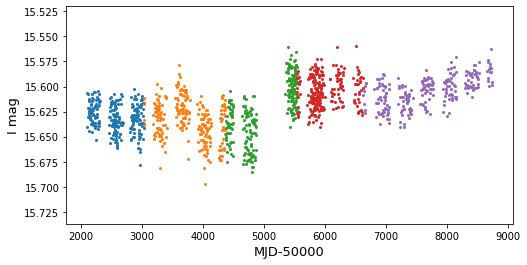

In [179]:
orb = orbchunks(141,0,findpd=True,plotlc=True)

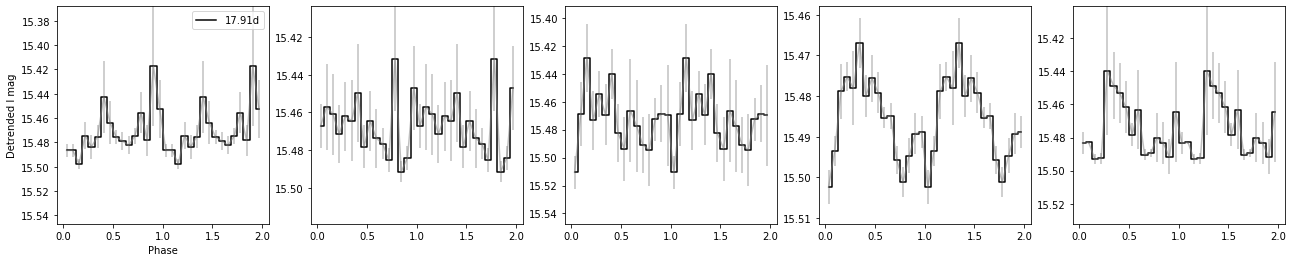

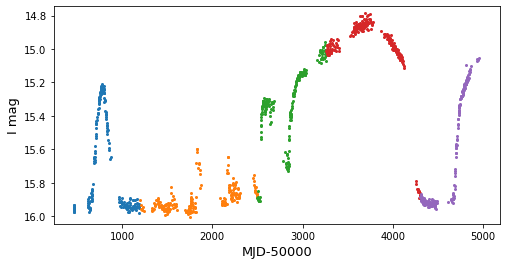

In [180]:
#one that also didn't look as good with the whole LC folded
orb = orbchunks(19,0,findpd=True,plotlc=True)

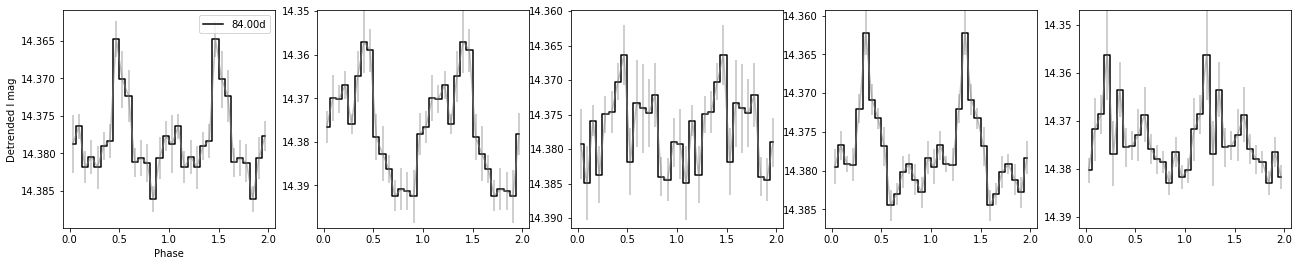

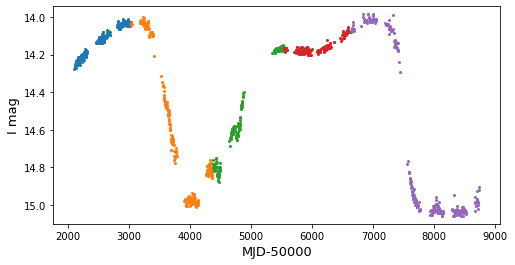

In [185]:
orb = orbchunks(2,0,findpd=True,plotlc=True)

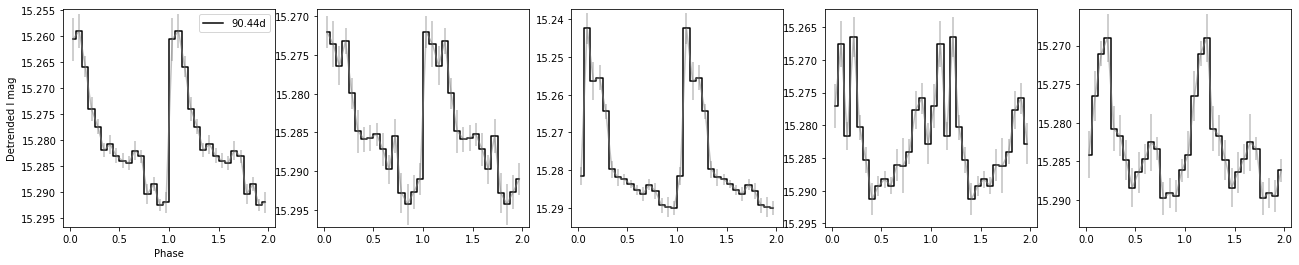

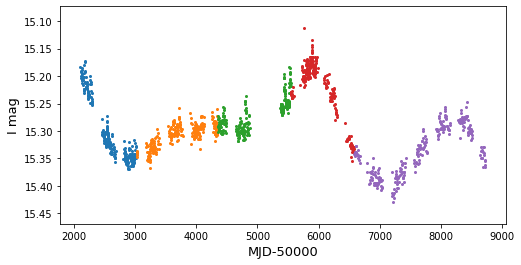

In [186]:
orb = orbchunks(22,0,findpd=True,plotlc=True)

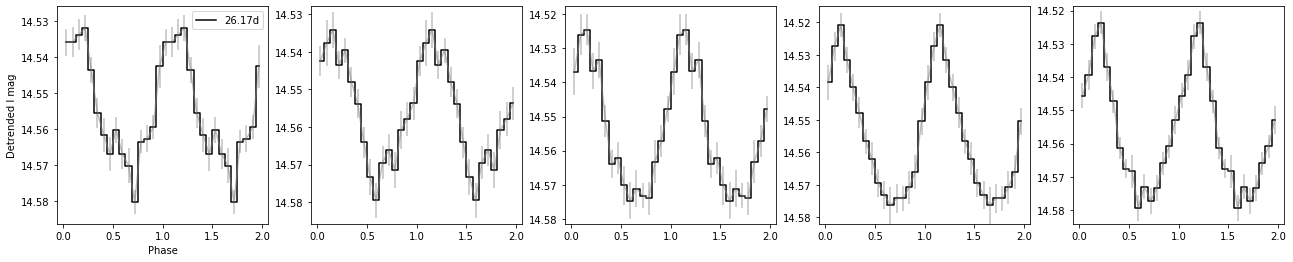

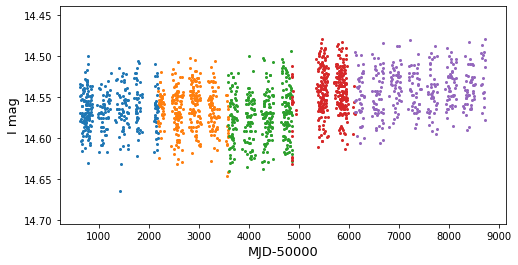

In [194]:
orb = orbchunks(64,0,findpd=True,plotlc=True) #relatively quite stable (whether 26.17 or 26.19 but perhaps can differentiate by phase)

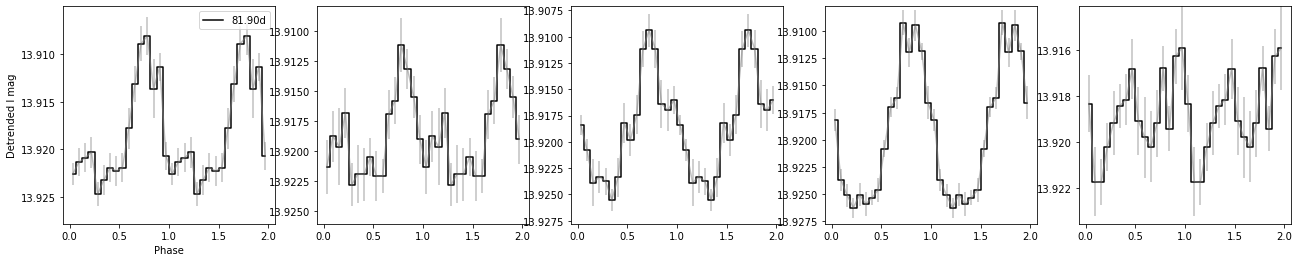

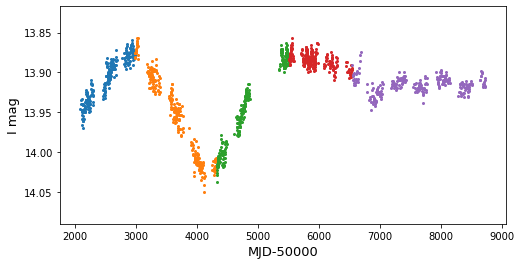

In [197]:
orb = orbchunks(4,0,findpd=True,plotlc=True)

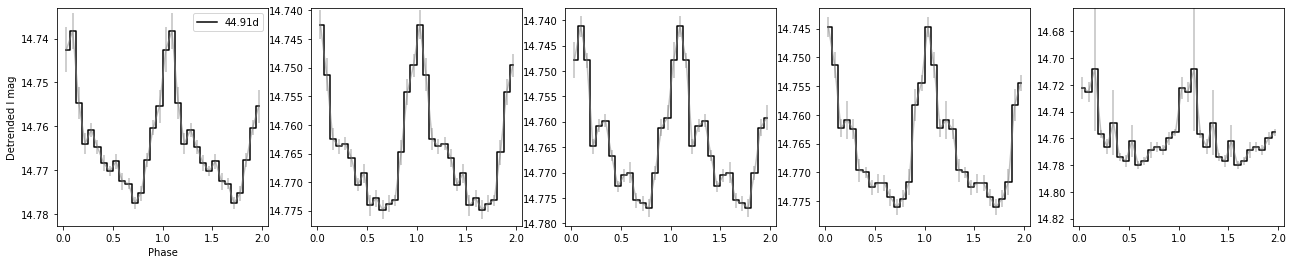

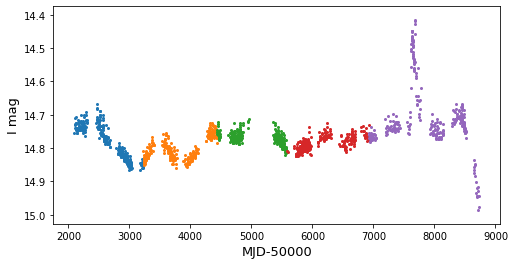

In [198]:
orb = orbchunks(9,0,findpd=True,plotlc=True) #very consistent; end could be b/c of difficult detrending (see errors)

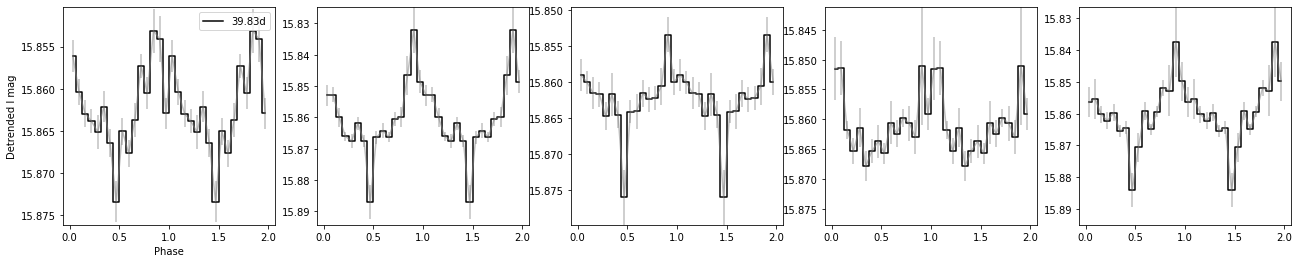

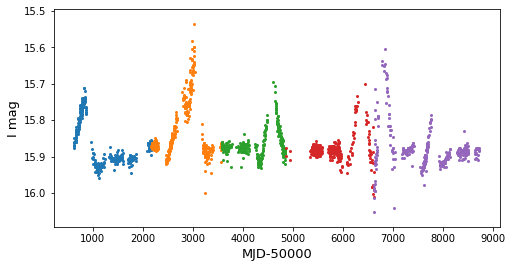

In [199]:
orb = orbchunks(10,0,findpd=True,plotlc=True) #interesting shape w/ dips

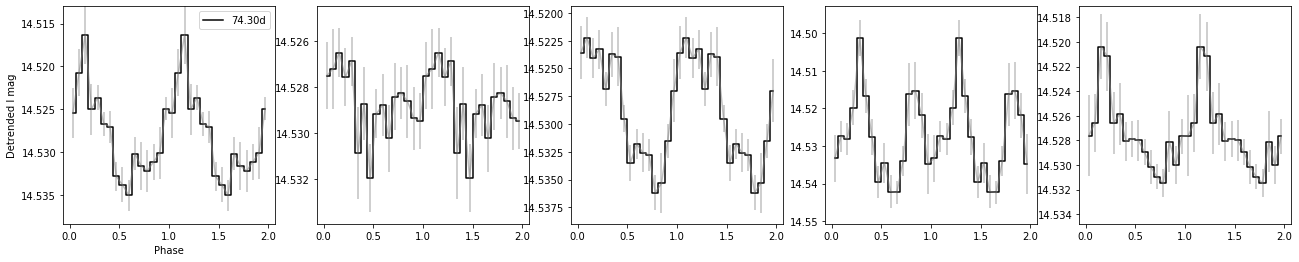

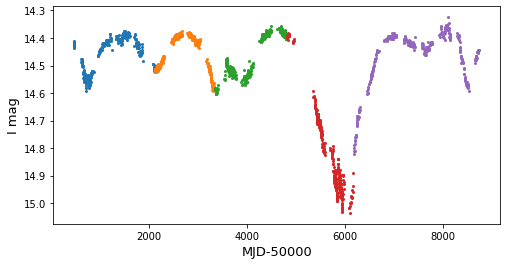

In [200]:
orb = orbchunks(16,0,findpd=True,plotlc=True)

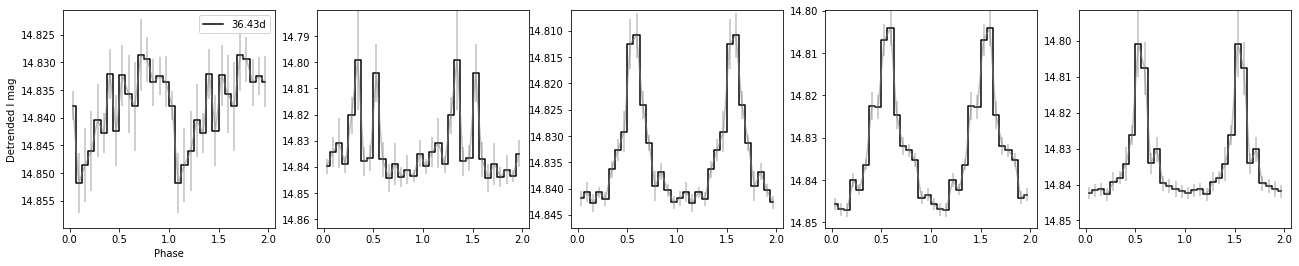

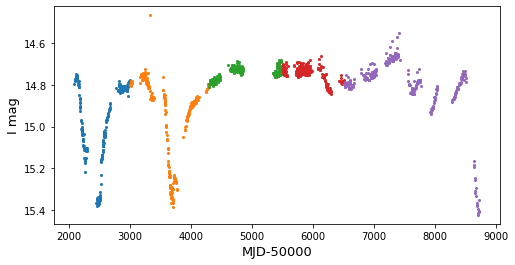

In [201]:
orb = orbchunks(17,0,findpd=True,plotlc=True) #check if detrending issue or physical

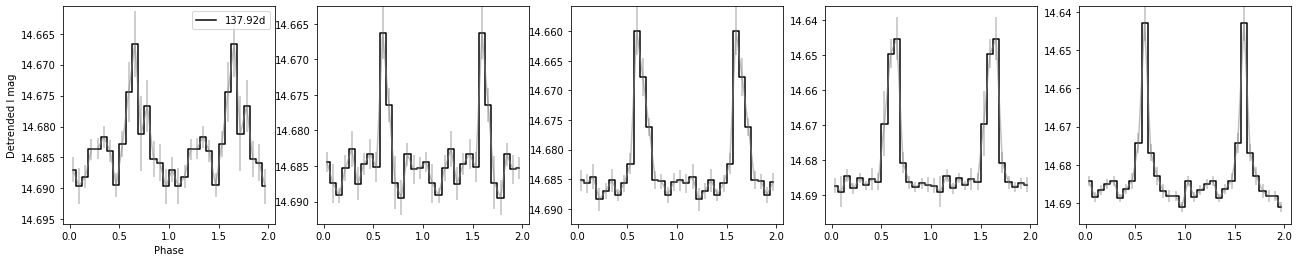

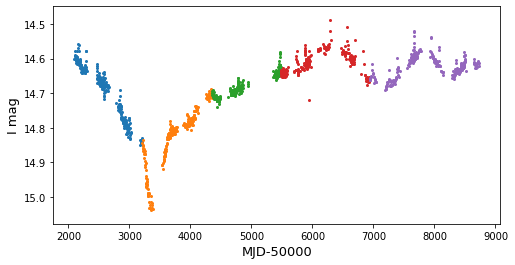

In [202]:
orb = orbchunks(23,0,findpd=True,plotlc=True)

empty file for OIII I


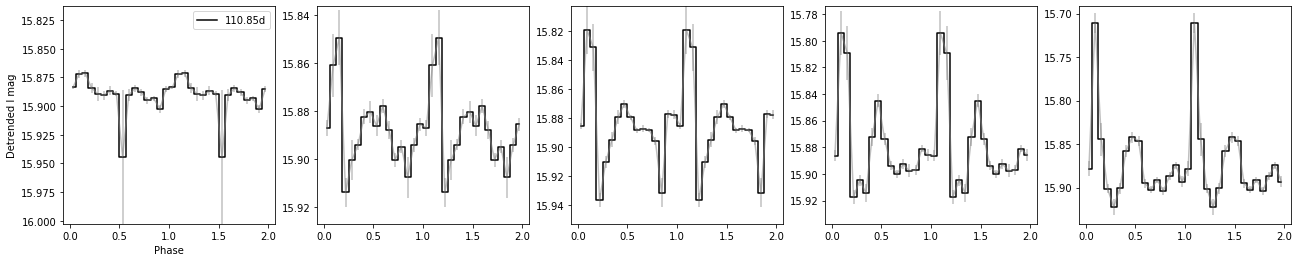

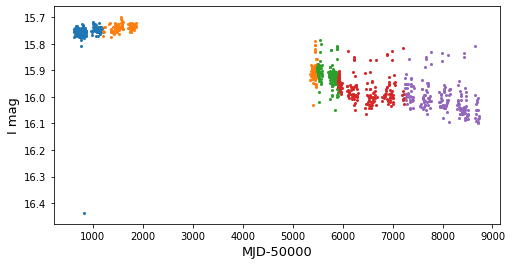

In [204]:
orb = orbchunks(25,0,findpd=True,plotlc=True) #meaning of double-peaked shape?

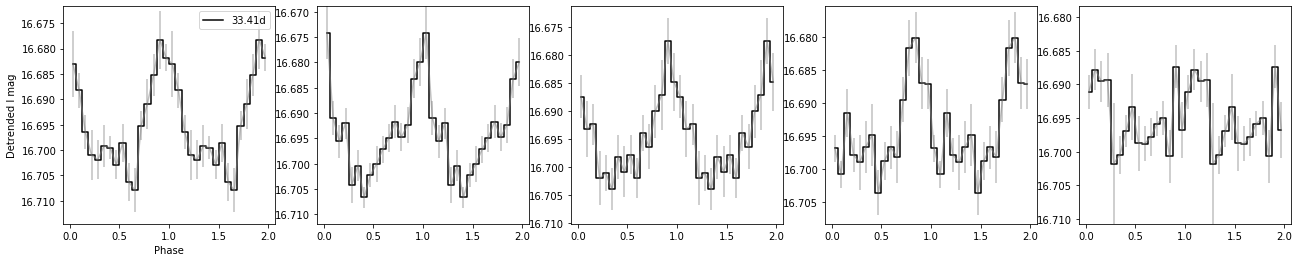

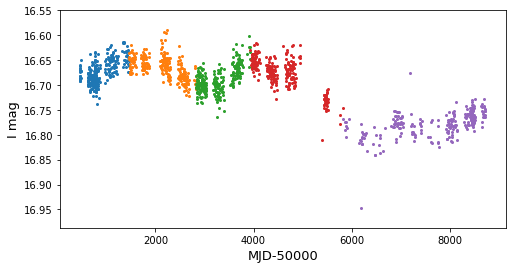

In [205]:
orb = orbchunks(26,0,findpd=True,plotlc=True)

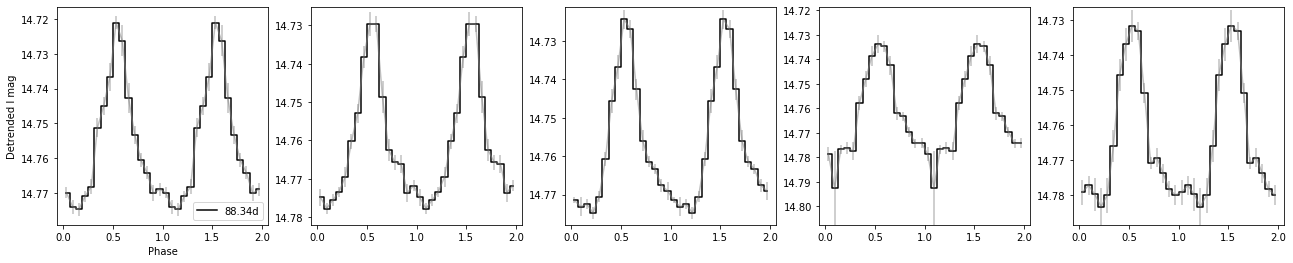

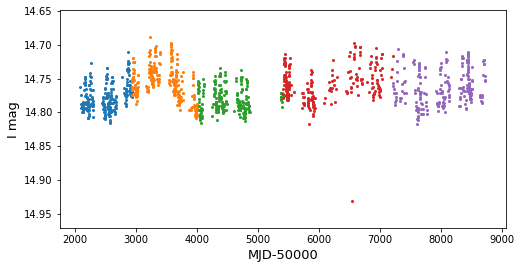

In [206]:
orb = orbchunks(28,0,findpd=True,plotlc=True)

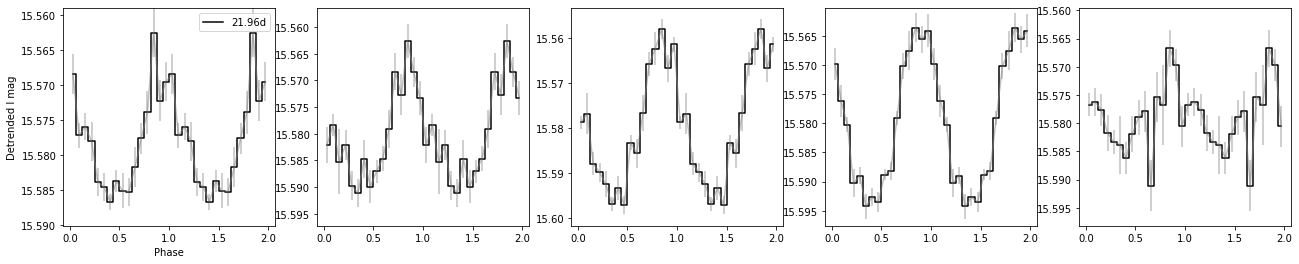

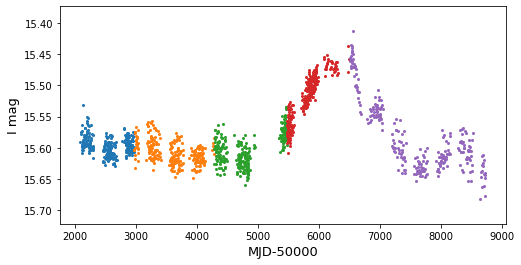

In [207]:
orb = orbchunks(30,0,findpd=True,plotlc=True)

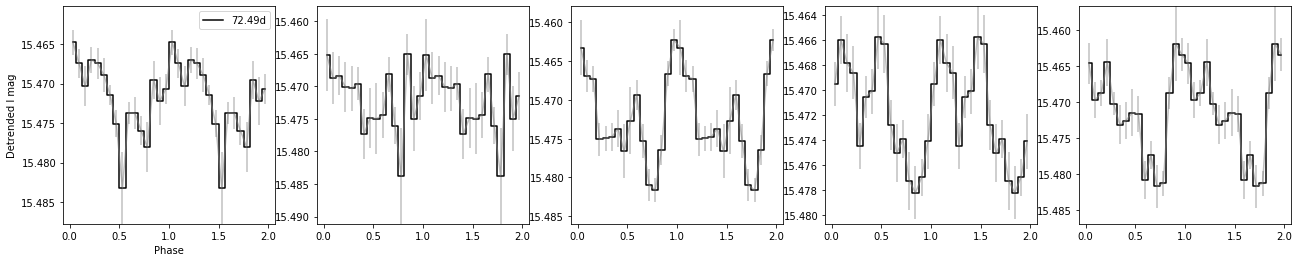

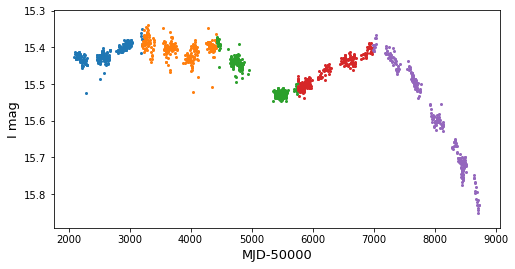

In [208]:
orb = orbchunks(34,0,findpd=True,plotlc=True)

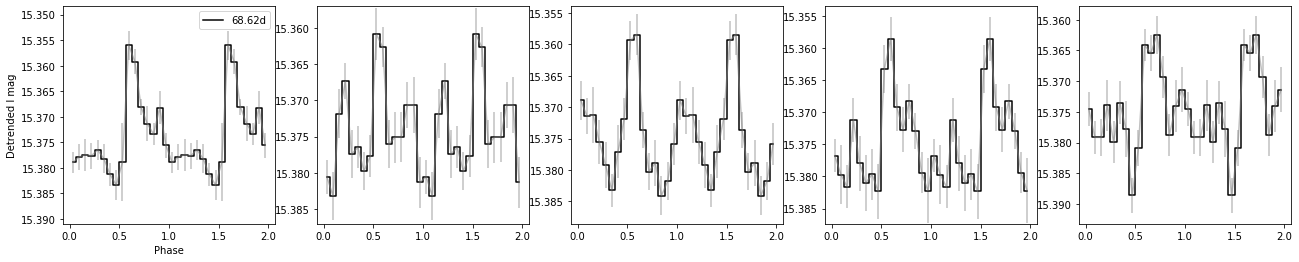

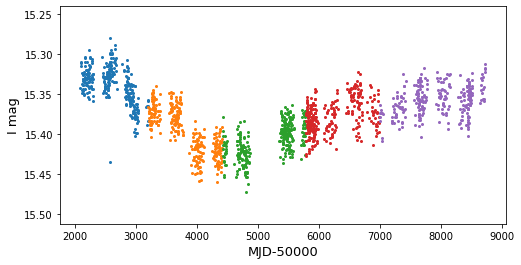

In [209]:
orb = orbchunks(36,0,findpd=True,plotlc=True) #should follow up

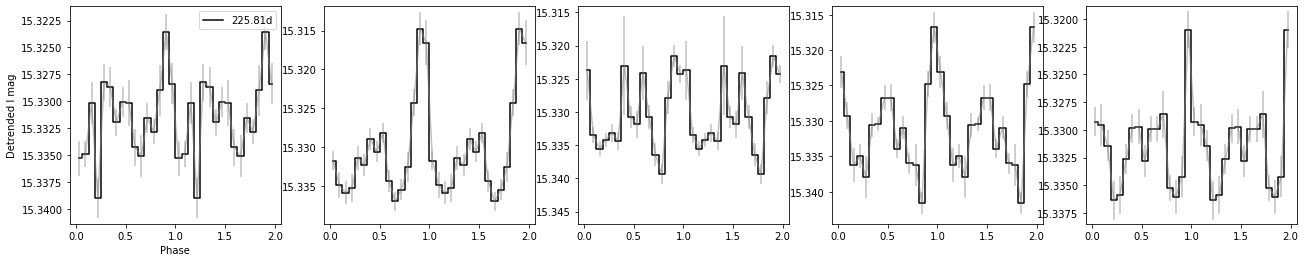

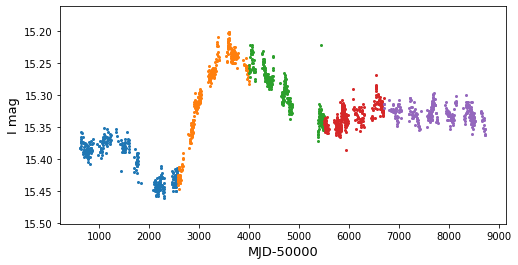

In [212]:
orb = orbchunks(40,0,findpd=True,plotlc=True)

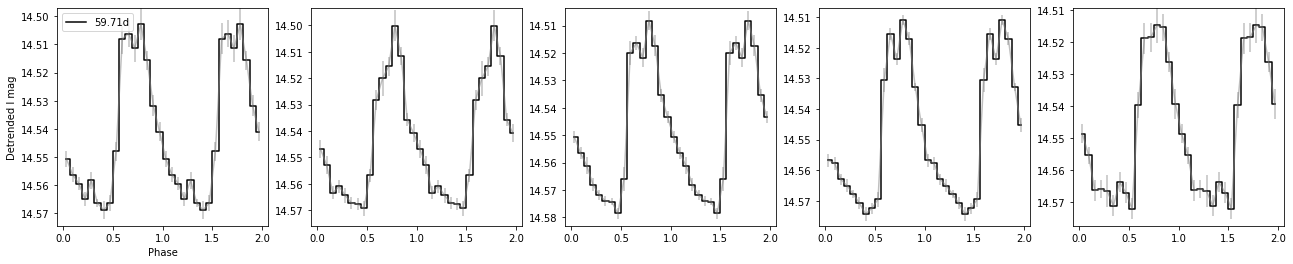

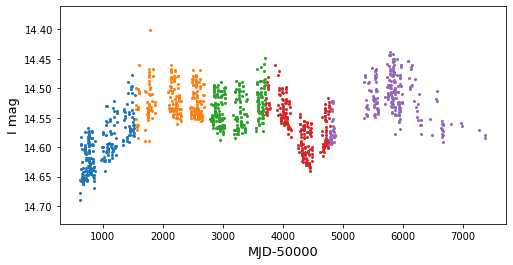

In [213]:
orb = orbchunks(45,0,findpd=True,plotlc=True) #consistent

In [215]:
# orb = orbchunks(48,0,findpd=True,plotlc=True) #figure out error here

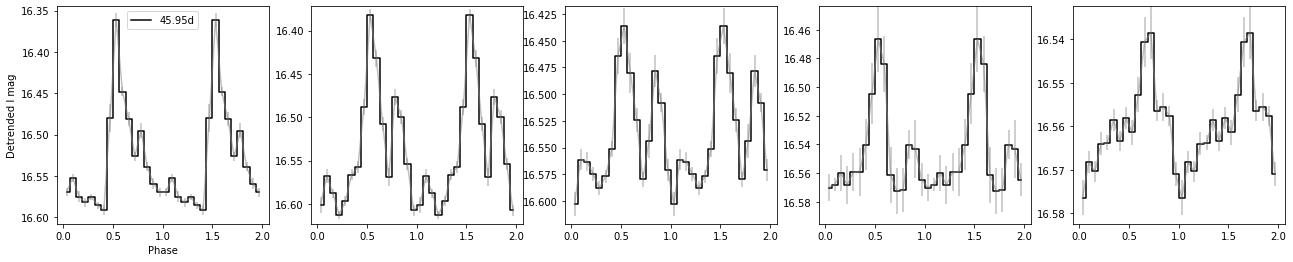

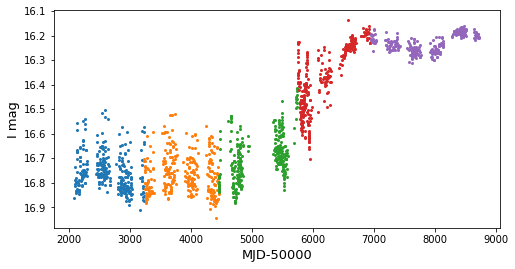

In [216]:
orb = orbchunks(50,0,findpd=True,plotlc=True) #follow this up

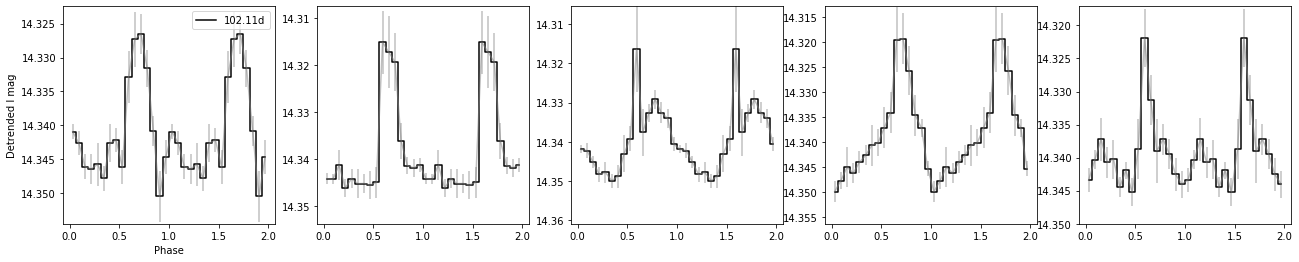

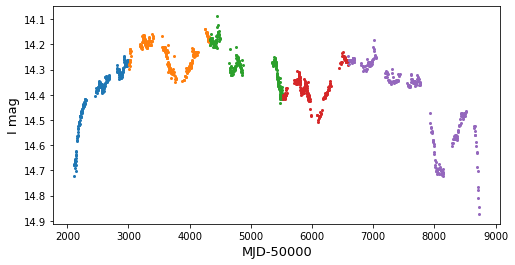

In [217]:
orb = orbchunks(62,0,findpd=True,plotlc=True)

In [219]:
# orb = orbchunks(63,0,findpd=True,plotlc=True)